In [290]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

def random_acc(R, NR):
    positive_samples = R
    negative_samples = NR
    total_samples = positive_samples + negative_samples
    
    # For random guessing, the probability of guessing a sample correctly is:
    # (probability of guessing a positive correctly + probability of guessing a negative correctly) / total possibilities
    
    # The probability of guessing a positive sample correctly is the proportion of positive samples,
    # and similarly for negative samples.
    
    random_guess_accuracy = (positive_samples/total_samples * positive_samples/total_samples) + \
                            (negative_samples/total_samples * negative_samples/total_samples)
    return random_guess_accuracy


In [2]:
pwd

'/home/was966/Research/mims-conceptor/baseline'

In [3]:
data_path = '../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [4]:
#cohorts = pd.Series(cohorts).map(size).to_list()

random_acc

In [293]:
df_label.response_label

346

In [383]:
cohort_rgc = df_label.groupby(['cohort']).response_label.apply(lambda x: random_acc(x.value_counts()['R'], x.value_counts()['NR'])).sort_values()
cohort_rgc

cohort
Hugo           0.502959
Gide           0.504597
Zhao           0.507200
Liu            0.527295
SU2CLC1        0.532488
MGH            0.543253
Snyder         0.555556
Allen          0.555556
SU2CLC2        0.564800
Miao           0.584775
IMmotion150    0.587438
Kim            0.608889
IMVigor210     0.647764
Riaz           0.684737
Choueiri       0.695312
Rose           0.705088
Name: response_label, dtype: float64

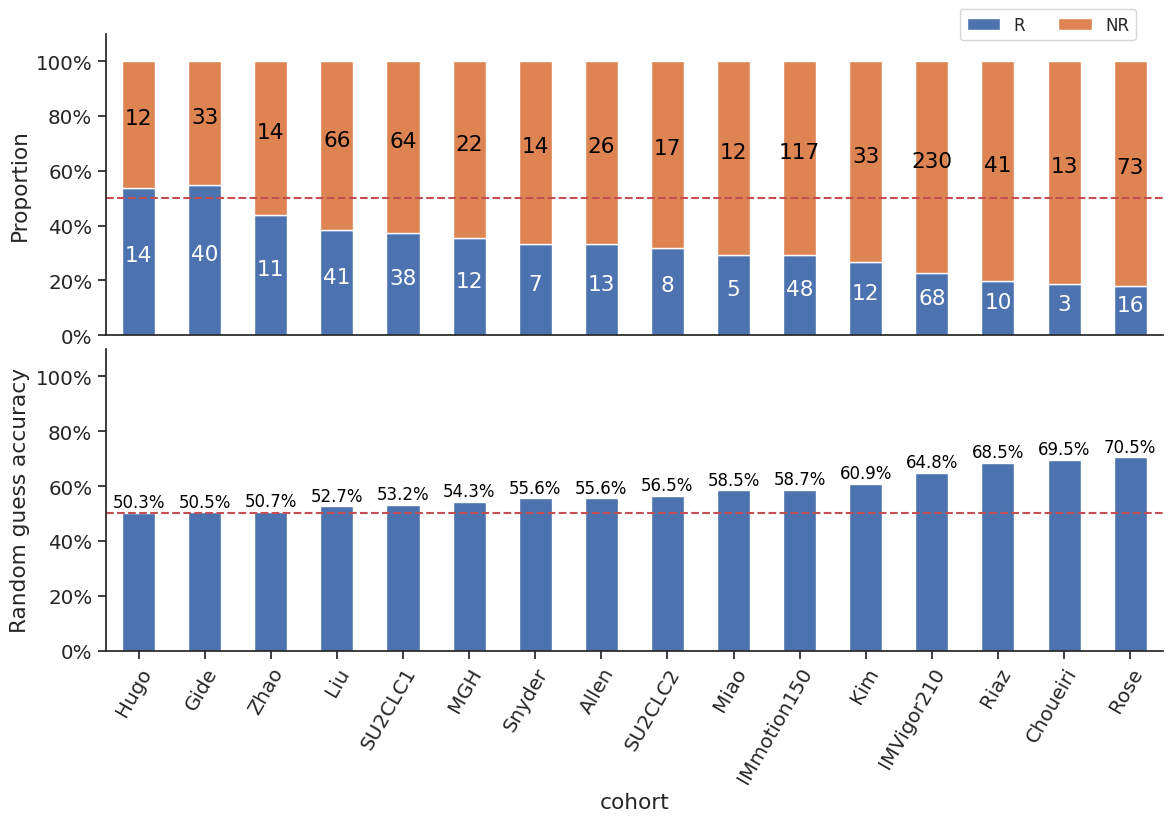

In [608]:
df = df_label.groupby(['cohort', 'response_label']).size().unstack()
df = df.loc[cohort_rgc.index]

# Normalize the R and NR values to get proportions for the stacked bar lengths
df['R_prop'] = df['R'] / (df['R'] + df['NR'])
df['NR_prop'] = df['NR'] / (df['R'] + df['NR'])


fig, (ax1, ax2) = plt.subplots(figsize=(12, 8.5), nrows=2, sharex=True, sharey=False)

# Plot a stacked bar plot with normalized proportions
df[['R_prop', 'NR_prop']].plot(kind='bar', stacked=True, ax = ax1)

h,l = ax1.get_legend_handles_labels()
ax1.legend(h[:2],["R", "NR"],  ncols =2, fancybox  = True, bbox_to_anchor =  (0.8, 0.95), fontsize=12)


# Annotate the actual numbers on the bars
for i, (index, row) in enumerate(df.iterrows()):
    # Annotate the responder count
    ax1.text(i, row['R_prop']/2, str(int(row['R'])), ha='center',color='white')
    ax1.text(i, row['R_prop'] + row['NR_prop']/2, str(int(row['NR'])), ha='center', color='black')

ax1.set_ylabel('Proportion')



cohort_rgc.sort_values().plot(kind='bar' , ax = ax2)
for i in range(len(cohort_rgc)):
    ax2.text(i, cohort_rgc.iloc[i] + 0.02 ,  '{:.1%}'.format(cohort_rgc.iloc[i]) ,
             ha='center', color='black', fontdict={'fontsize':12})


ax2.set_ylabel('Random guess accuracy')


ax1.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
ax2.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax2.set_xticklabels(
    cohort_rgc.index, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax2.axhline(y=0.5, color='r', linestyle='--')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)

ax1.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)


vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


fig.tight_layout(h_pad = 0.1)

'87.6%'

In [473]:
# from sklearn.metrics import accuracy_score, average_precision_score

# accs = []
# aps = []

# for _ in range(1000):
#     y = [1] * 10 + [0] * 90
#     pred = [np.random.binomial(n=1, p=0.1)] * 100
#     accs.append(accuracy_score(y, np.round(pred)))
#     aps.append(average_precision_score(y, pred))

# print(np.mean(accs))
# print(np.mean(aps))

In [474]:
large_cohorts = [ 'SU2CLC1',
 'Liu',
 'IMmotion150',
 'IMVigor210']

medium_cohorts = [ 'MGH',
 'Allen',
 'Kim',
 'Riaz',
 'Gide',
 'Rose',]

small_cohort = ['Choueiri',
 'Miao',
 'Snyder',
 'SU2CLC2',
 'Zhao',
 'Hugo',]

skcm_cohorts = [
 'Hugo',
 'MGH',
 'Allen',
 'Riaz',
 'Gide',
 'Liu',]

blca_cohorts = [
 'IMVigor210',
 'Rose',
 'Snyder']

kirc_cohorts = ['Choueiri', 
                'IMmotion150', 
                'Miao']

kc = ['Kim', 'Zhao'] + large_cohorts
train_cohorts = skcm_cohorts #[ 'IMVigor210', 'Liu']#small_cohort + medium_cohorts #['IMVigor210', 'Zhao', 'IMmotion150', 'Kim', 'SU2CLC1', 'Liu']
test_cohorts = skcm_cohorts #['IMmotion150'] #[ 'IMmotion150', 'IMVigor210']

In [475]:
# IMVigor210	BLCA
# Rose	BLCA
# Snyder	BLCA
# Zhao	GBM
# Choueiri	KIRC
# IMmotion150	KIRC
# Miao	KIRC
# Kim	STAD
# SU2CLC1	LUAD
# SU2CLC2	LUSC
# Gide	SKCM
# Hugo	SKCM
# Liu	SKCM
# Riaz	SKCM
# Allen	SKCM
# MGH	SKCM

In [476]:
cohorts

['Choueiri',
 'Miao',
 'Snyder',
 'SU2CLC2',
 'Zhao',
 'Hugo',
 'MGH',
 'Allen',
 'Kim',
 'Riaz',
 'Gide',
 'Rose',
 'SU2CLC1',
 'Liu',
 'IMmotion150',
 'IMVigor210']

## loading bechmarks

In [478]:
from glob import glob
csvs = glob('./experiment_results/CTCT/CTCT_*/metric_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    df = df[df.train_cohort != df.test_cohort]	
    res.append(df)

data1 = pd.concat(res)
data1.shape

(5280, 9)

## loading conceptor

In [479]:
# #csvs = glob('../paper/01_model_performance/01_CTCT/CTCT/CTCT_*/metric_performance.tsv')

# csvs = glob('/home/was966/Research/mims-conceptor/paper/01_model_performance/tmpignore/01_all-cohort-to-cohort-transfer/CTCT/*/*.csv')
# res = []
# for csv in csvs:
#     df = pd.read_csv(csv, index_col =0, sep=',')

#     df['test_cohort'] = df.Test_cohort
#     df['train_cohort'] = df.Train_cohort
#     df = df[df.train_cohort != df.test_cohort]	
#     #df['mode'] = csv.split('/')[-2].split('_')[1]
#     res.append(df)
# data2 = pd.concat(res)
# data2.shape

In [480]:
csvs = glob('../paper/01_model_performance/01_CTCT/CTCT5//CTCT_*/metric_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')

    df = df[df.train_cohort != df.test_cohort]	
    df['mode'] = csv.split('/')[-2].split('_')[1]
    res.append(df)
data2 = pd.concat(res)
data2.shape

(960, 8)

## Merge & analysis

In [680]:
data = data2._append(data1).reset_index(drop=True)
data['transfer'] = data.train_cohort + '-to-'+data.test_cohort
data['test_cohort_RGC'] = data.test_cohort.map(cohort_rgc)

data.head()

,train_cohort,test_cohort,ROC,PRC,F1,ACC,MCC,mode,best_C,transfer,test_cohort_RGC
0,Allen,Choueiri,0.333333,0.138068,0.000000,0.750000,-0.124035,FFT,NaN,Allen-to-Choueiri,0.695312
1,Allen,Gide,0.550000,0.605938,0.000000,0.452055,0.000000,FFT,NaN,Allen-to-Gide,0.504597
2,Allen,Hugo,0.452381,0.541290,0.117647,0.423077,-0.148608,FFT,NaN,Allen-to-Hugo,0.502959
3,Allen,IMVigor210,0.527877,0.245656,0.000000,0.771812,0.000000,FFT,NaN,Allen-to-IMVigor210,0.647764
4,Allen,IMmotion150,0.548077,0.304063,0.000000,0.709091,0.000000,FFT,NaN,Allen-to-IMmotion150,0.587438


In [681]:
data1.shape,data2.shape, data.shape

((5280, 9), (960, 8), (6240, 11))

In [682]:
datas = data[data.train_cohort.isin(train_cohorts) & data.test_cohort.isin(test_cohorts)]
datas.shape

(780, 11)

In [683]:
# data.groupby(['mode', 'train_cohort']).ROC.mean().unstack().mean(axis=1).sort_values()

In [684]:
# CTL        0.087279
# ICA        0.087926
# Teff       0.091466
# CIS        0.103539
# PFT        0.081424

In [685]:
data_mt = data[(data.ACC > data.test_cohort_RGC + 0.05) & (data.MCC > 0)]
df_mt = data_mt.groupby('mode').size().to_frame('# of Meaningful Transfer')

data_nt = data[(data.ACC < data.test_cohort_RGC) & (data.MCC < 0)]
df_nt = data_nt.groupby('mode').size().to_frame('# of Negative Transfer')

data['meaningful_transfer'] = data.index.isin(data_mt.index)
data['negative_transfer'] = data.index.isin(data_nt.index)

dft = df_mt.join(df_nt)
dft

,# of Meaningful Transfer,# of Negative Transfer
mode,,
CAF,14,110
CD8,58,63
CIS,78,64
CKS,45,106
CTL,81,73
CTLA4,50,71
FFT,59,33
GEP,64,68
GeneBio,67,53


In [686]:
colors = sns.color_palette('PRGn',10)
colors

[(0.44198385236447524, 0.14855824682814303, 0.4921953094963475),
 (0.5730872741253364, 0.3853902345251826, 0.639830834294502),
 (0.7134948096885813, 0.5859284890426758, 0.7702422145328719),
 (0.8546712802768166, 0.766320645905421, 0.87520184544406),
 (0.9403306420607459, 0.906728181468666, 0.9420991926182237),
 (0.9155709342560554, 0.956247597078047, 0.904959630911188),
 (0.7803921568627453, 0.9121107266435987, 0.7568627450980394),
 (0.5633217993079587, 0.8069204152249136, 0.5547866205305654),
 (0.3044982698961938, 0.6408304498269897, 0.3480968858131488),
 (0.09550173010380622, 0.45059592464436754, 0.20492118415993849)]

In [687]:
mt_color = colors[-1]
nt_color = colors[2]

Text(0.5, 0, 'Method')

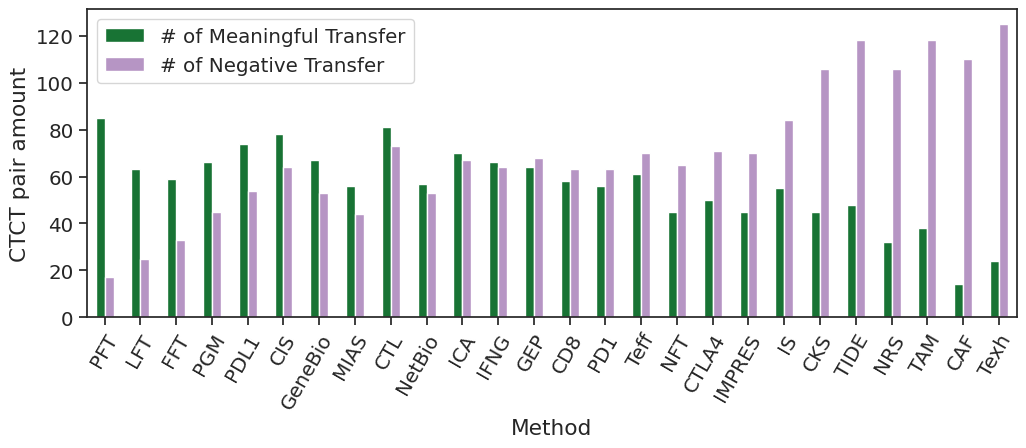

In [688]:
fig, ax = plt.subplots(figsize=(12, 4),  )
x_order = (dft[dft.columns[1]] - dft[dft.columns[0]]).sort_values().index
dft = dft.loc[x_order]

dft.plot(kind='bar', ax=ax, color= [mt_color, nt_color], alpha = 1)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

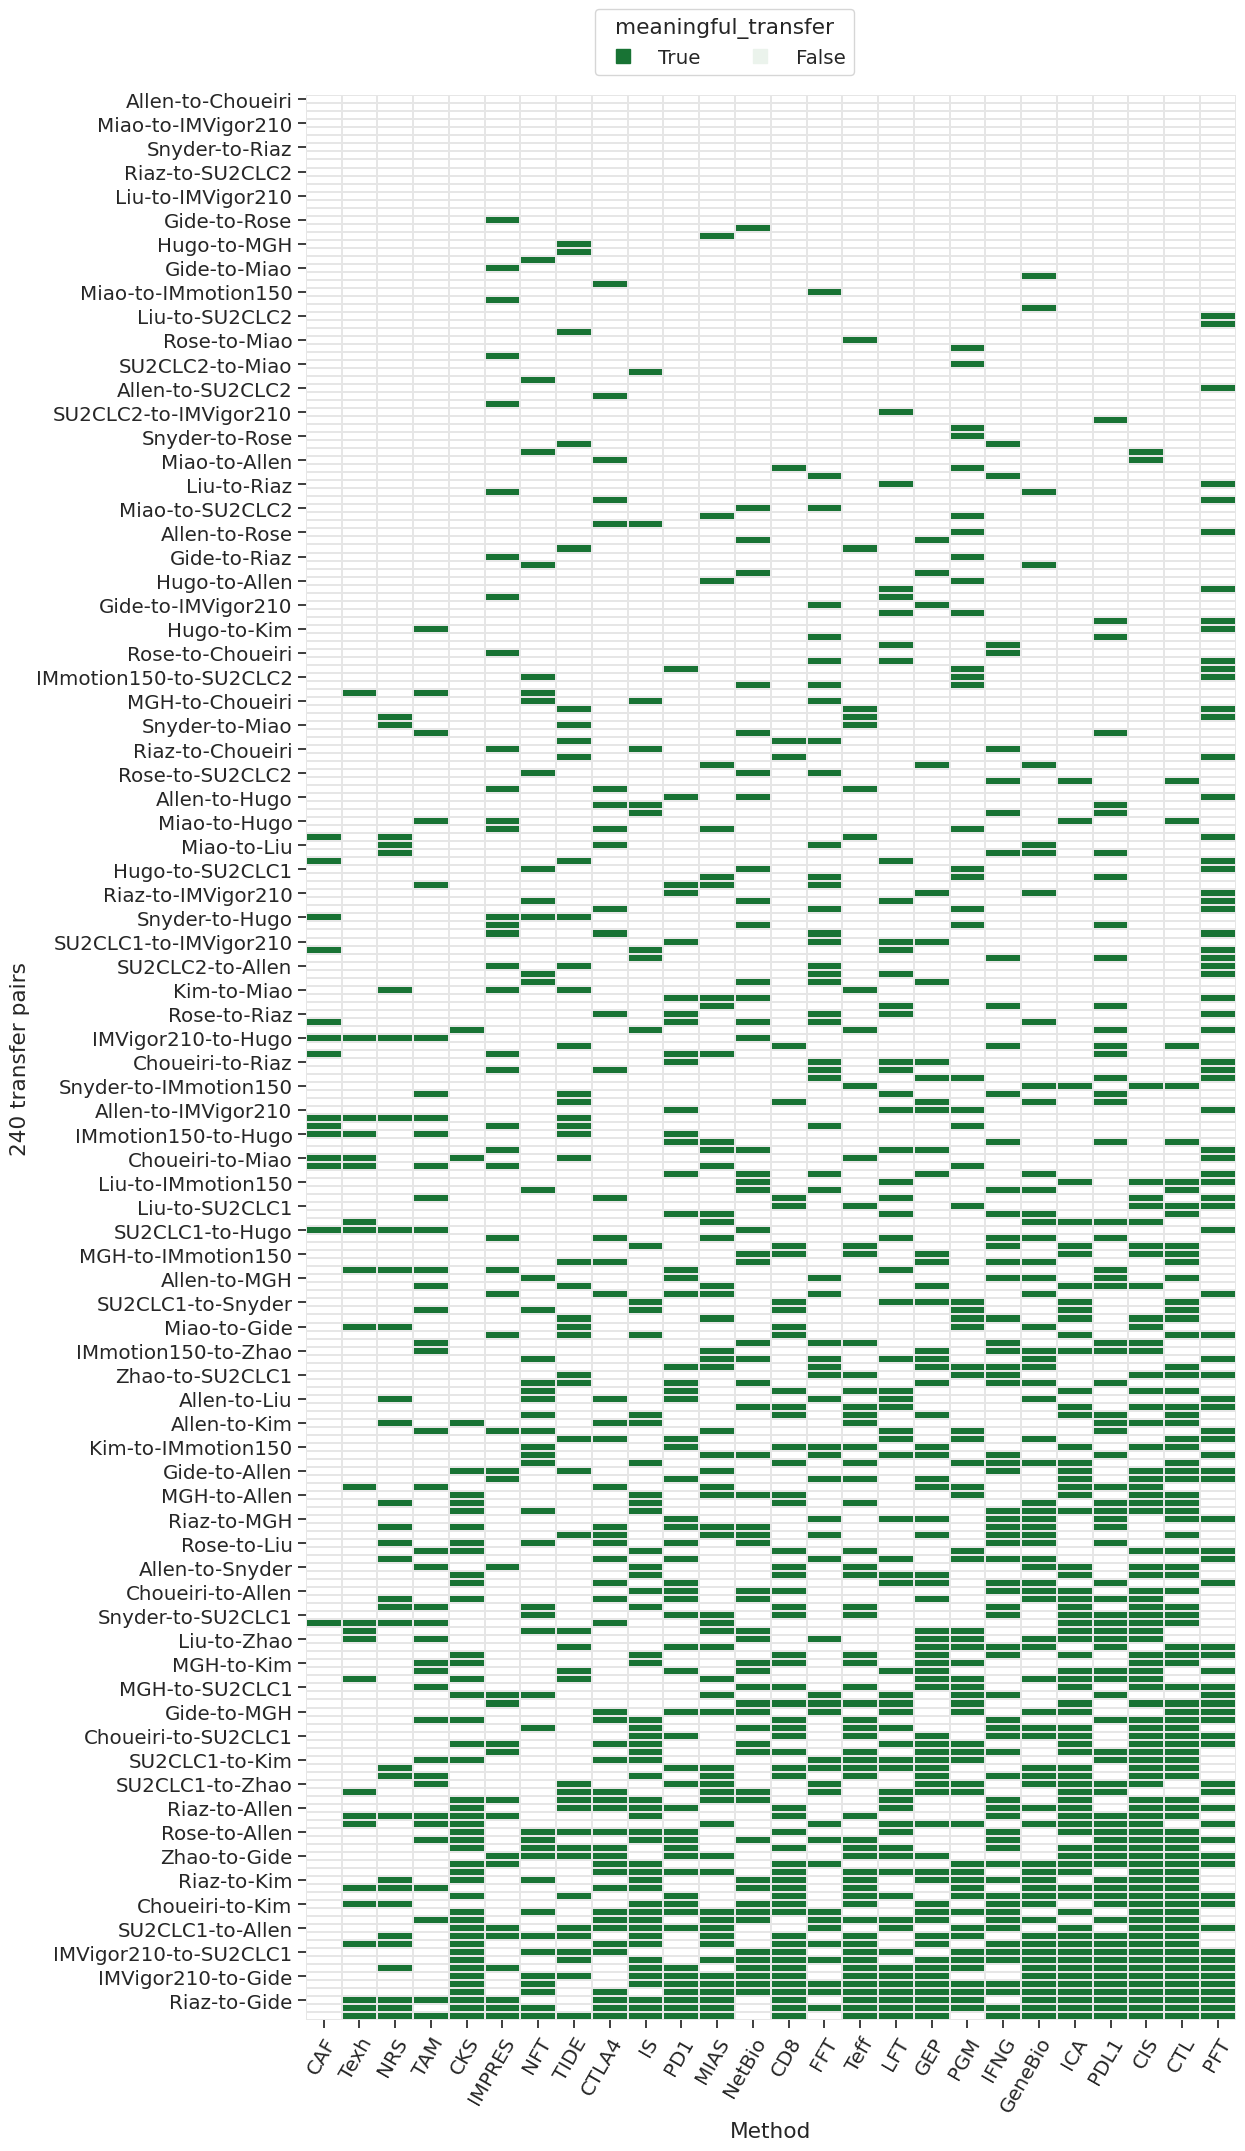

In [721]:
values =  'meaningful_transfer'
color = mt_color

dfb1 = pd.pivot_table(data, columns = 'mode', index='transfer', values = values )

dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

x_order = dfb1.sum().sort_values().index
y_order = dfb1.sum(axis=1).sort_values().index
dfb1 = dfb1[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(12, 25))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap = sns.light_palette(color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('240 transfer pairs')
ax.set_xlabel('Method')


l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap[0], label= 'True' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap[1], label= 'False' )[0]

patches = [l1, l2]

ax.legend(handles=patches, bbox_to_anchor=(0.6,1.05),  loc='upper right', ncol=3, facecolor="w", numpoints=1, title=values, ) 

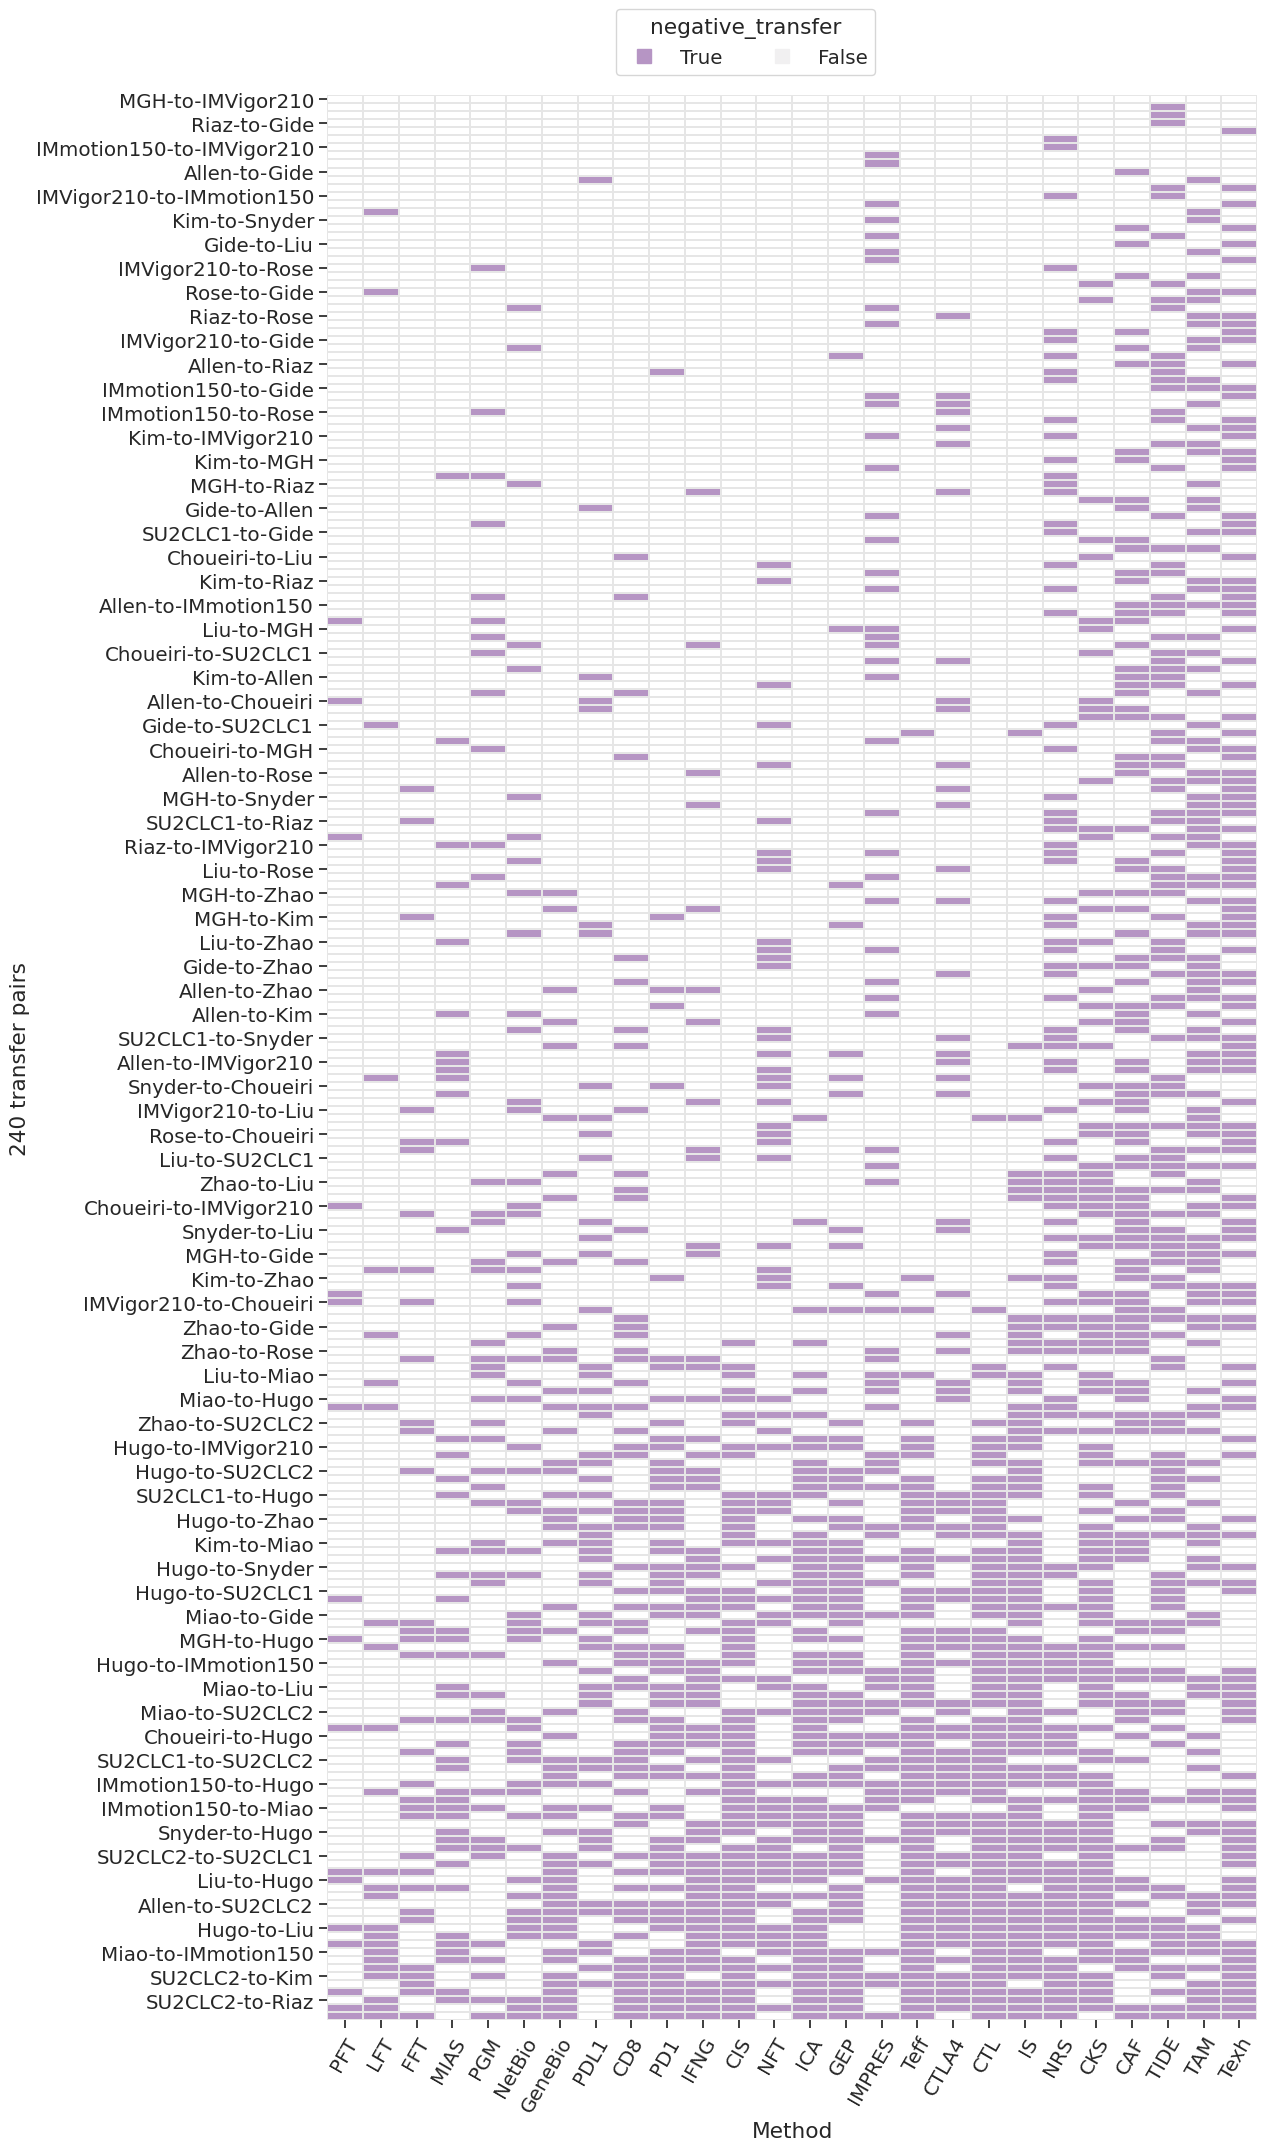

In [719]:
values =  'negative_transfer'
color = nt_color

dfb1 = pd.pivot_table(data, columns = 'mode', index='transfer', values = values )

dfb1 = pd.DataFrame(np.where(dfb1 !=0, dfb1, np.nan), index=dfb1.index, columns= dfb1.columns)

x_order = dfb1.sum().sort_values().index
y_order = dfb1.sum(axis=1).sort_values().index
dfb1 = dfb1[x_order].loc[y_order]

fig, ax = plt.subplots(figsize=(12, 25))
# sns.heatmap(dfb1, cmap = 'Greens', ax=ax, linewidths = 0.01)
cmap = sns.light_palette(color, n_colors =  2, reverse=True)

sns.heatmap(dfb1, 
        cmap = cmap, ax = ax, #vmax = data.max()-0.01,
        cbar=False,  #cbar_kws = dict(use_gridspec=False,location="bottom"), 
        linewidths=0.003, linecolor = '0.9')#

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke
ax.set_ylabel('240 transfer pairs')
ax.set_xlabel('Method')


l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap[0], label= 'True' )[0]
l2 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap[1], label= 'False' )[0]

patches = [l1, l2]

ax.legend(handles=patches, bbox_to_anchor=(0.6,1.05),  loc='upper right', ncol=3, facecolor="w", numpoints=1, title=values, ) 

In [712]:
cmap = sns.light_palette(color, n_colors =  2, reverse=True)


(0.9452440394558331, 0.9426522395191453, 0.9465344271933477)

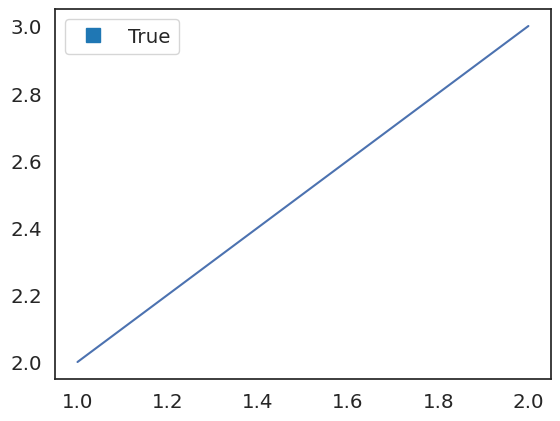

In [720]:
# To plot a rectangle (square marker) in the legend, you can use the 'plot' function with marker set to "s" for square
import matplotlib.pyplot as plt

# Create a sample plot
plt.figure()
plt.plot([1, 2], [2, 3])  # Dummy plot

# Creating custom legend with a square marker for 'True'
cmap = plt.get_cmap('tab10')  # Getting a colormap to choose a color
l1 = plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=cmap(0), label='True')[0]

# Creating a legend with our custom legend handle
plt.legend(handles=[l1])

# Show the plot
plt.show()


## Melenoma Only

In [611]:
mdata = data[data.train_cohort.isin(skcm_cohorts) & data.test_cohort.isin(skcm_cohorts)]

mdata_mt = mdata[(mdata.ACC > mdata.test_cohort_RGC + 0.05) & (mdata.MCC > 0)]

mdf_mt = mdata_mt.groupby('mode').size().to_frame('# of Meaningful Transfer')

mdata_nt = mdata[(mdata.ACC < mdata.test_cohort_RGC) & (mdata.MCC < 0)]
mdf_nt = mdata_nt.groupby('mode').size().to_frame('# of Negative Transfer')

mdft = mdf_mt.join(mdf_nt)
mdft

,# of Meaningful Transfer,# of Negative Transfer
mode,,
CAF,3,15
CD8,6,7
CIS,8,10
CKS,10,12
CTL,12,10
CTLA4,11,8
FFT,10,5
GEP,8,7
GeneBio,12,8


Text(0.5, 0, 'Method')

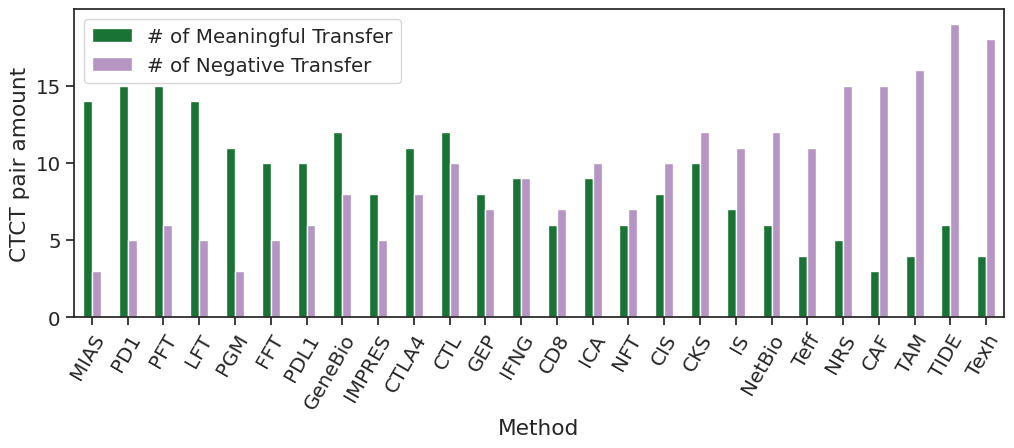

In [613]:
fig, ax = plt.subplots(figsize=(12, 4),  )
x_order = (mdft[dft.columns[1]] - mdft[mdft.columns[0]]).sort_values().index
mdft = mdft.loc[x_order]

mdft.plot(kind='bar', ax=ax, color= [colors[-1], colors[2]], alpha = 1)
ax.set_ylabel('CTCT pair amount')

ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# # #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Method')

In [615]:
data

,train_cohort,test_cohort,ROC,PRC,F1,ACC,MCC,mode,best_C,transfer,test_cohort_RGC
0,Allen,Choueiri,0.333333,0.138068,0.000000,0.750000,-0.124035,FFT,NaN,Allen-to-Choueiri,0.695312
1,Allen,Gide,0.550000,0.605938,0.000000,0.452055,0.000000,FFT,NaN,Allen-to-Gide,0.504597
2,Allen,Hugo,0.452381,0.541290,0.117647,0.423077,-0.148608,FFT,NaN,Allen-to-Hugo,0.502959
3,Allen,IMVigor210,0.527877,0.245656,0.000000,0.771812,0.000000,FFT,NaN,Allen-to-IMVigor210,0.647764
4,Allen,IMmotion150,0.548077,0.304063,0.000000,0.709091,0.000000,FFT,NaN,Allen-to-IMmotion150,0.587438
...,...,...,...,...,...,...,...,...,...,...,...
6235,Zhao,Riaz,0.504878,0.179294,0.303030,0.549020,0.048652,Texh,0.1,Zhao-to-Riaz,0.684737
6236,Zhao,Rose,0.530822,0.193470,0.275862,0.528090,0.026343,Texh,0.1,Zhao-to-Rose,0.705088
6237,Zhao,SU2CLC1,0.512747,0.376814,0.376471,0.480392,-0.061420,Texh,0.1,Zhao-to-SU2CLC1,0.532488
6238,Zhao,SU2CLC2,0.595588,0.446290,0.421053,0.560000,0.082918,Texh,0.1,Zhao-to-SU2CLC2,0.564800


In [620]:
hue_order = ['PFT', 'LFT', 'FFT', 'MIAS',  'PGM', 'PD1', 'PDL1'] #'Teff' 'FFT', 'NFT',

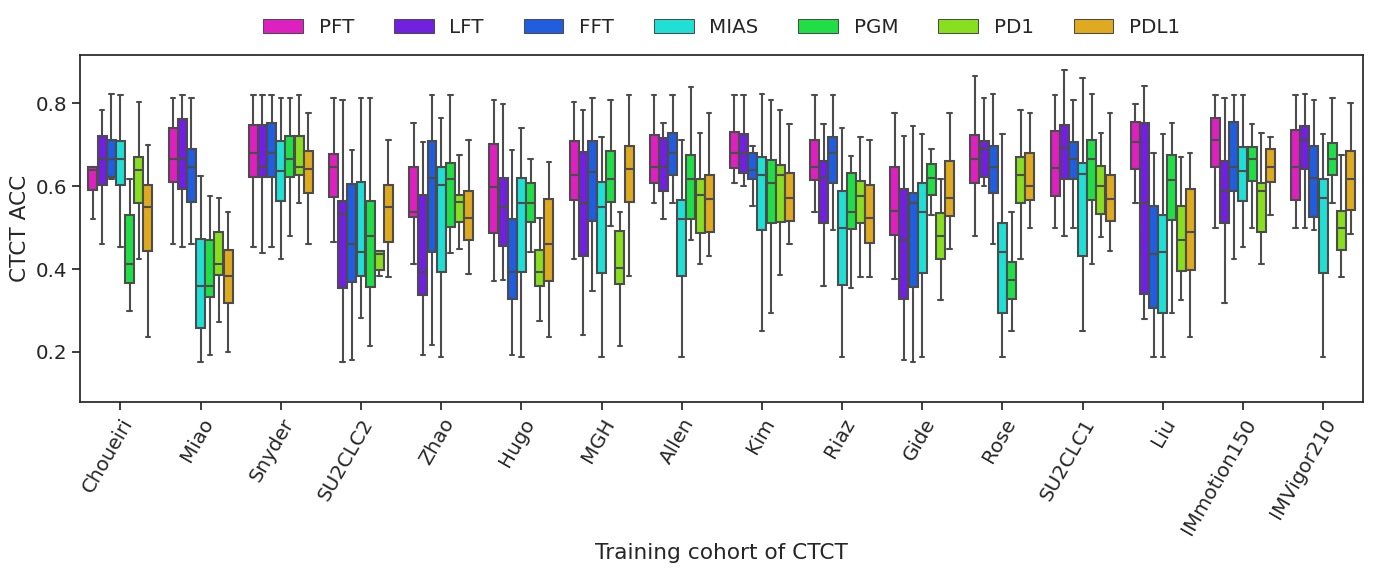

In [621]:
fig, ax = plt.subplots(figsize=(14,6))
x = 'train_cohort'
y = 'ACC'
hue = 'mode'
# order = ['PFT','PGM', 'ICA'] # 'Teff'

# data[x] = data[x]  + '\n(n='  + data['n_train'].astype(str) + ')'

x_order = cohorts

palette = sns.palettes.color_palette('hsv_r', len(hue_order))


res = []
for r in x_order:
    d1 = data[data[x] == r]
    res.append(d1)
datap = pd.concat(res)

# hue_order = data.groupby(['mode', 'train_cohort']).MCC.mean().unstack().mean(axis=1).sort_values().index

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)


g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()

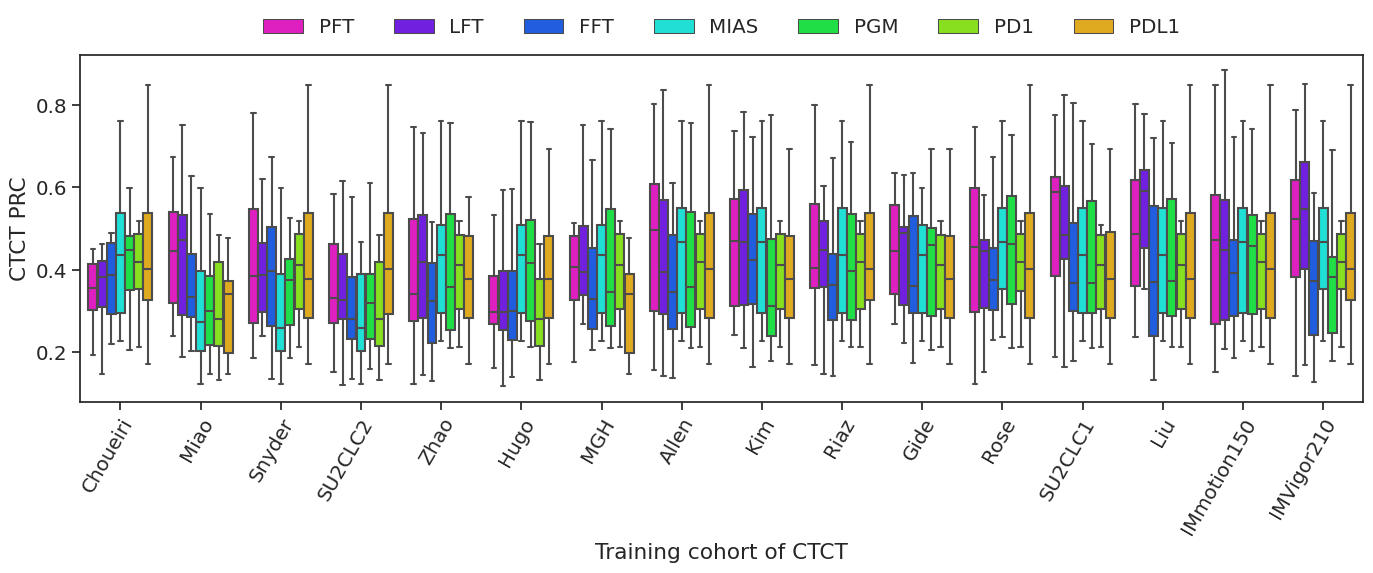

In [622]:
fig, ax = plt.subplots(figsize=(14,6))


x = 'train_cohort'
y = 'PRC'
hue = 'mode'
# order = ['PFT','PGM', 'ICA'] # 'Teff'

# data[x] = data[x]  + '\n(n='  + data['n_train'].astype(str) + ')'
x_order = cohorts
palette = sns.palettes.color_palette('hsv_r', len(hue_order))

res = []
for r in x_order:
    d1 = data[data[x] == r]
    res.append(d1)
datap = pd.concat(res)

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)


g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)


ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()

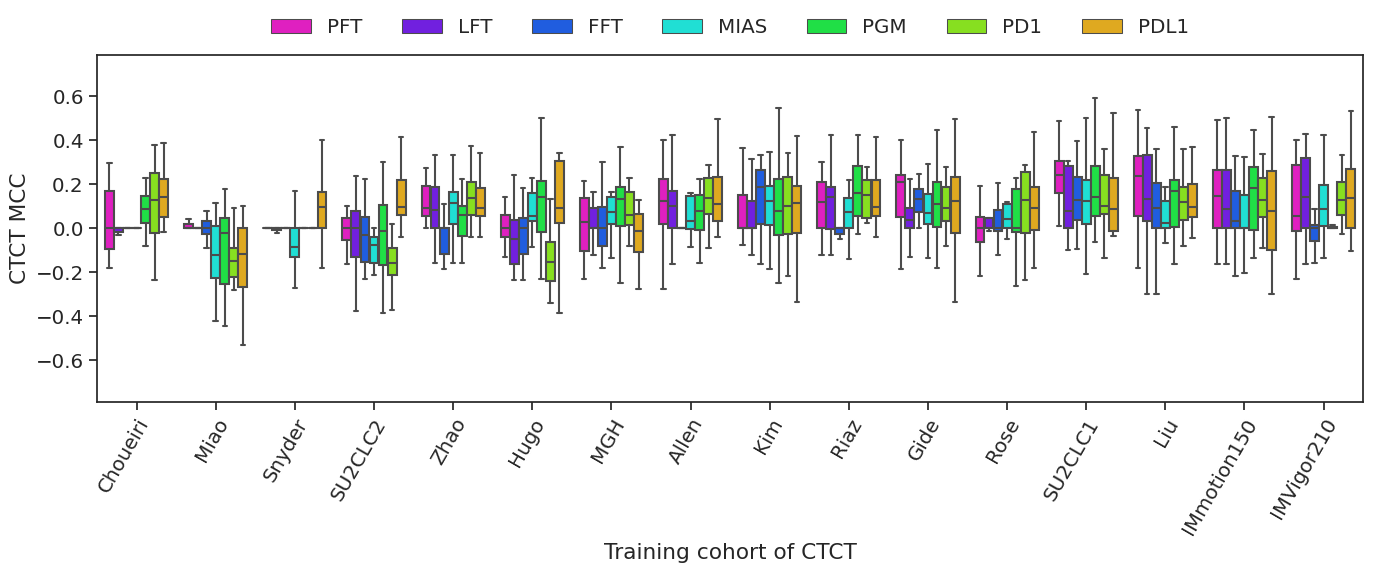

In [623]:
x = 'train_cohort'
y = 'MCC'
hue = 'mode'

x_order = cohorts
palette = sns.palettes.color_palette('hsv_r', len(hue_order))

res = []
for r in x_order:
    d1 = data[data[x] == r]
    res.append(d1)
datap = pd.concat(res)

fig, ax = plt.subplots(figsize=(14,6))

sns.boxplot(data = datap, x = x, y = y, hue = hue, order = x_order, #errorbar=('ci', 95),
            hue_order= hue_order, ax = ax,  palette = palette, fliersize = 0)

g = sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1),
                ncol= len(hue_order),  title=None, frameon=False)

#sns.lineplot(data = datap, x = x, y = y, hue = hue, errorbar=('ci', 50), )
ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
# #fig.savefig('./avg_refined_distribution.pdf')
ax.set_xticklabels(
    x_order, 
    rotation=60, 
    ha="right",  
    rotation_mode="anchor")  # <====== HERE is the ke

ax.set_xlabel('Training cohort of CTCT')
ax.set_ylabel('CTCT %s' % y)

fig.tight_layout()

<Axes: xlabel='mode', ylabel='transfer'>

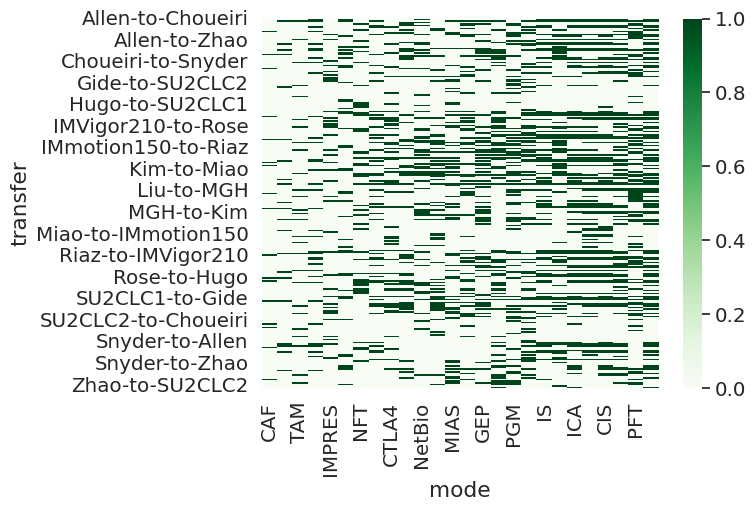

In [231]:
dfb.columns

Index(['TAM', 'CAF', 'NRS', 'NFT', 'Teff', 'IMPRES', 'Texh', 'TIDE', 'CD8',
       'NetBio', 'FFT', 'GEP', 'IS', 'CTLA4', 'IFNG', 'CKS', 'CIS', 'PDL1',
       'ICA', 'GeneBio', 'PD1', 'PGM', 'CTL', 'LFT', 'PFT', 'MIAS'],
      dtype='object', name='mode')

<Axes: xlabel='mode', ylabel='transfer'>

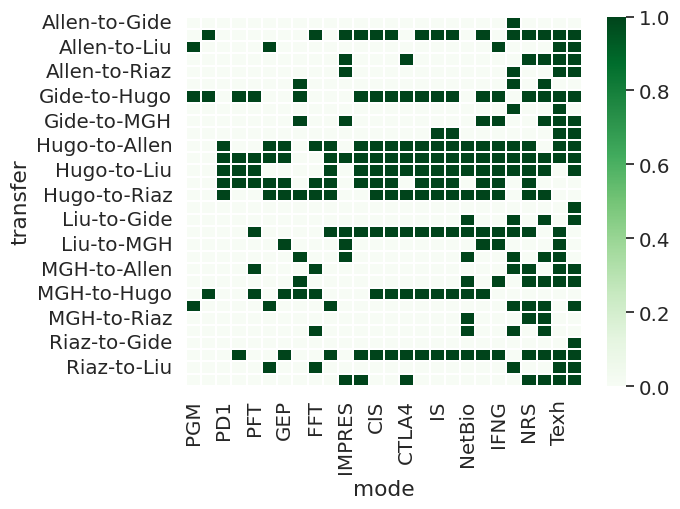

In [287]:
dft1 = pd.pivot_table(datap, columns = 'mode', index='transfer', values = 'MCC')
dfb1 = dft1 < 0.0

dft2 = pd.pivot_table(datap, columns = 'mode', index='transfer', values = 'ACC')
dfb2 = dft2 < 0.7

dfb = dfb1 & dfb2 

x_order = dfb.sum().sort_values().index
#y_order = dfb.sum(axis=1).sort_values().index
dfb = dfb[x_order] #.loc[y_order]
sns.heatmap(dfb*1, linewidths=0.1, cmap='Greens')


In [252]:
dfb.columns

Index(['PGM', 'MIAS', 'PD1', 'LFT', 'PFT', 'CD8', 'GEP', 'PDL1', 'FFT',
       'GeneBio', 'IMPRES', 'NFT', 'CIS', 'CTL', 'CTLA4', 'ICA', 'IS', 'Teff',
       'NetBio', 'CKS', 'IFNG', 'CAF', 'NRS', 'TAM', 'Texh', 'TIDE'],
      dtype='object', name='mode')

In [256]:
# Given positive samples (30) and negative samples (50), calculate the accuracy of random guessing.



0.7222222222222223